<a href="https://colab.research.google.com/github/PalmWS/sleep-stage-classification/blob/main/Sleep_Stage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install MNE library

In [ ]:
!pip install mne

In [ ]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Load Data for Visualization

In [ ]:
drive.mount('/content/drive/')
data_root = '/content/drive/MyDrive/Brain Code 101/Dataset/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
raw_train = mne.io.read_raw_edf(f"{data_root}sleep-cassette/SC4001E0-PSG.edf", preload=True, infer_types = True, stim_channel="Event marker")
#raw = mne.io.read_raw_edf(f"{data_root}sleep-cassette/SC4001E0-PSG.edf", preload=True, infer_types = True, stim_channel="Event marker")
annot_train = mne.read_annotations(f"{data_root}sleep-cassette/SC4001EC-Hypnogram.edf")

#raw.set_annotations(annot)
raw_train.set_annotations(annot_train, emit_warning=False)

Extracting EDF parameters from /content/drive/MyDrive/Brain Code 101/Dataset/sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~424.6 MB, data loaded>

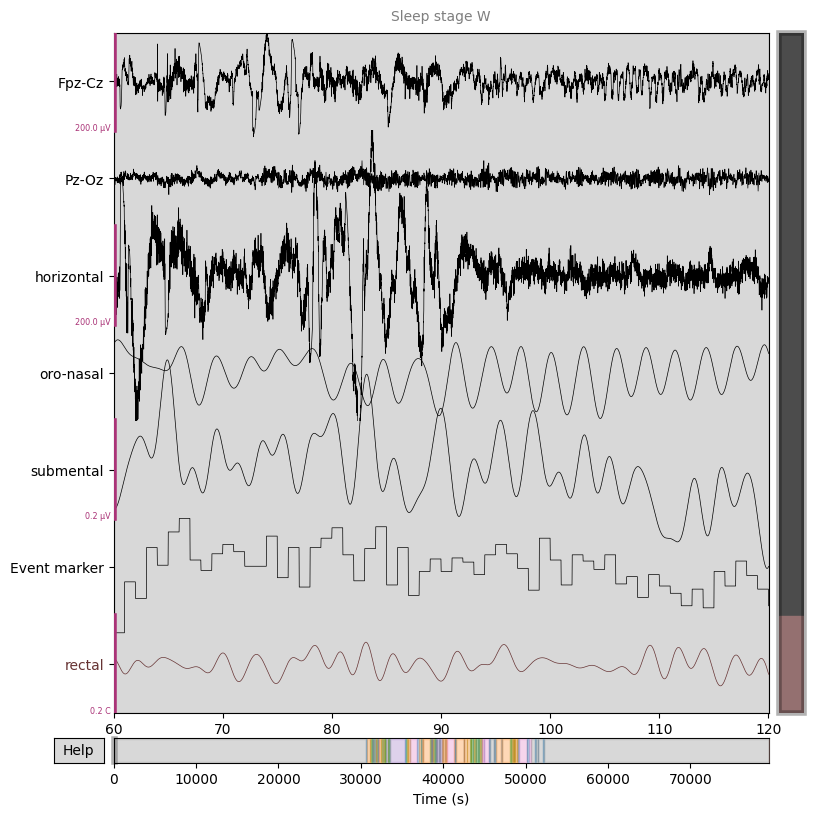

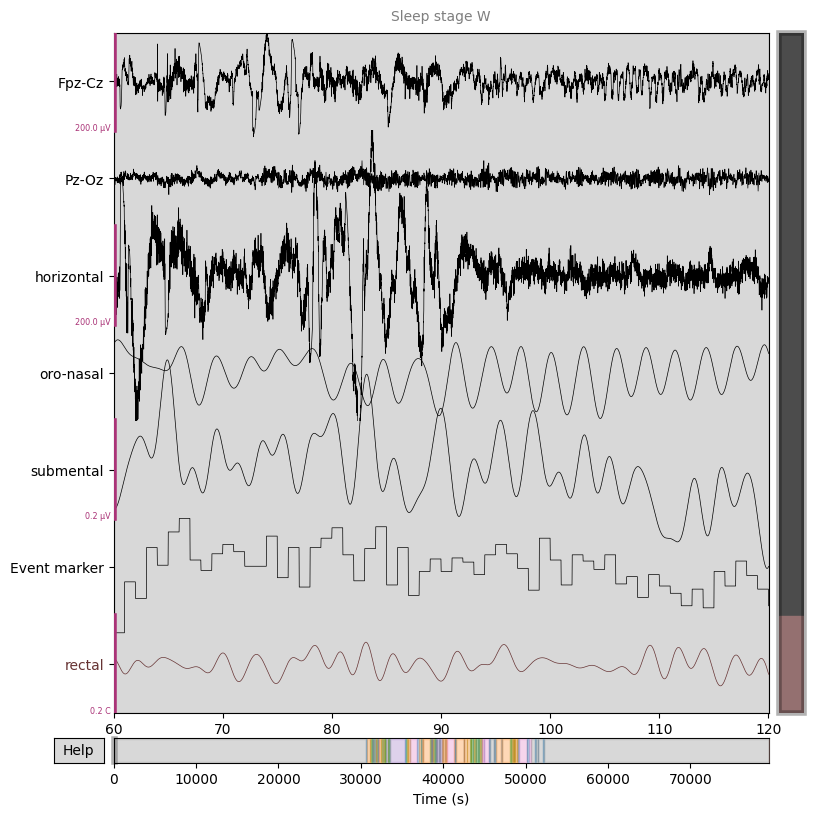

In [ ]:
raw_train.plot(
    start=60,
    duration=60,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1)
)

# Extract 30s events from annotations

ชุดข้อมูล Sleep Physionet ได้รับการใส่คำอธิบายประกอบโดยใช้ป้ายกำกับ 8 รายการ: Wake (W), Stage 1, Stage 2, Stage 3, Stage 4 ที่สอดคล้องกับช่วงตั้งแต่การนอนหลับตื้นไปจนถึงการนอนหลับลึก, REM sleep (R) โดยที่ REM เป็นตัวย่อของ Rapid Eye Movement, การเคลื่อนไหว (M) และ Stage (?) สำหรับส่วนที่ไม่มีคะแนน

เราจะทำงานเฉพาะกับ 5 ระยะ: ตื่น (W), ระยะ 1, ระยะ 2, ระยะ 3/4 และการนอนหลับ REM (R) ในการดำเนินการดังกล่าว เราใช้พารามิเตอร์ `event_id` ใน `mne.events_from_annotations()` เพื่อเลือกเหตุการณ์ที่เราสนใจ และเราเชื่อมโยงตัวระบุเหตุการณ์กับแต่ละรายการ

นอกจากนี้ การบันทึกยังมีขอบเขตการตื่นตัวนาน (W) ก่อนและหลังแต่ละคืน เพื่อจำกัดผลกระทบของความไม่สมดุลของชั้นเรียน เราจะตัดการบันทึกแต่ละครั้งโดยเก็บเวลาปลุกไว้เพียง 30 นาทีก่อนเกิดครั้งแรกและ 30 นาทีหลังจากระยะการนอนหลับครั้งสุดท้าย

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


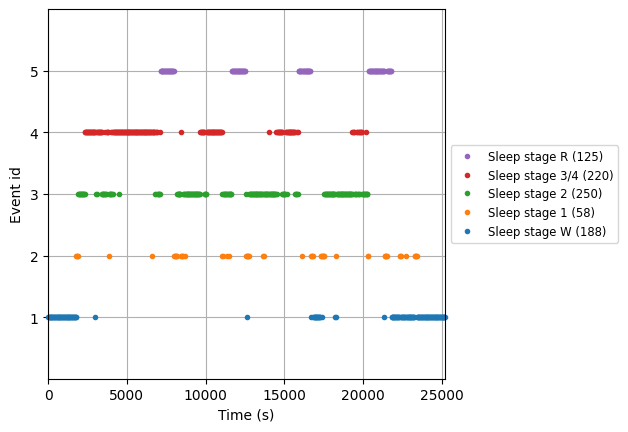

In [ ]:
annotation_desc_2_event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 4,
    "Sleep stage R": 5,
}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]["onset"] - 30 * 60, annot_train[-2]["onset"] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)

# create a new event_id that unifies stages 3 and 4
event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3/4": 4,
    "Sleep stage R": 5,
}

# plot events
fig = mne.viz.plot_events(
    events_train,
    event_id=event_id,
    sfreq=raw_train.info["sfreq"],
    first_samp=events_train[0, 0],
)

# keep the color-code for further plotting
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Create Epochs from the data based on the events found in the annotations

In [ ]:
tmax = 30.0 - 1.0 / raw_train.info["sfreq"]  # tmax in included

epochs_train = mne.Epochs(
    raw=raw_train,
    events=events_train,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)
del raw_train

print(epochs_train)

Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  841 events (good & bad), 0 – 29.99 s, baseline off, ~13 kB, data not loaded,
 'Sleep stage W': 188
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125>


# Applying the same steps to the test data from 2nd night

In [ ]:
raw_test = mne.io.read_raw_edf(
    f"{data_root}sleep-cassette/SC4002E0-PSG.edf", stim_channel="Event marker", infer_types=True, preload=True
)
annot_test = mne.read_annotations(f"{data_root}sleep-cassette/SC4002EC-Hypnogram.edf")
annot_test.crop(annot_test[1]["onset"] - 30 * 60, annot_test[-2]["onset"] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)
epochs_test = mne.Epochs(
    raw=raw_test,
    events=events_test,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)
del raw_test

print(epochs_test)

Extracting EDF parameters from /content/drive/MyDrive/Brain Code 101/Dataset/sleep-cassette/SC4002E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1127 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1127 events (good & bad), 0 – 29.99 s, baseline off, ~13 kB, data not 

# Feature Engineering

การสังเกตพล็อตความหนาแน่นสเปกตรัมพลังงาน (PSD) ของ Epochs ต่างๆ ที่จัดกลุ่มตามระยะการนอนหลับ เราจะเห็นว่าระยะการนอนหลับที่ต่างกันมีลายเซ็นที่แตกต่างกัน ลายเซ็นเหล่านี้ยังคงคล้ายกันระหว่างข้อมูลของคืนที่ 1 และคืนที่ 2

ส่วนที่เหลือของส่วนนี้เราจะสร้างคุณลักษณะ EEG ตามพลังงานสัมพัทธ์ในย่านความถี่เฉพาะเพื่อจับความแตกต่างระหว่างระยะการนอนหลับในข้อมูลของเรา

Using data from preloaded Raw for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 59 events and 3000 original

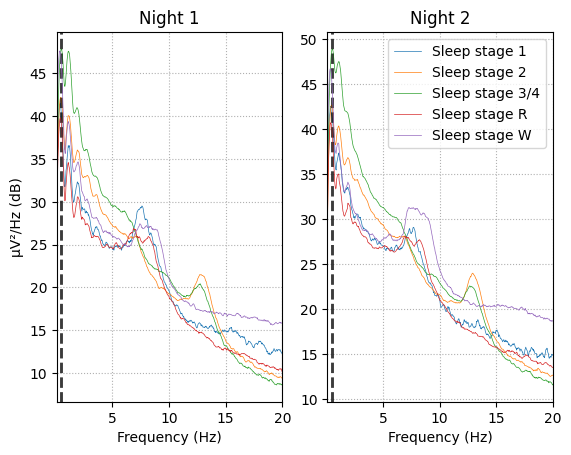

In [ ]:
# visualize Alice vs. Bob PSD by sleep stage.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2], ["Night 1", "Night 2"], [epochs_train, epochs_test]):
    for stage, color in zip(stages, stage_colors):
        spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=20.0)
        spectrum.plot(
            ci=None,
            color=color,
            axes=ax,
            show=False,
            average=True,
            spatial_colors=False,
            picks="data",
            exclude="bads",
        )
    ax.set(title=title, xlabel="Frequency (Hz)")
ax1.set(ylabel="µV²/Hz (dB)")
ax2.legend(ax2.lines[2::3], stages)

# Design a scikit-learn transformer from a Python function

สร้างฟังก์ชันเพื่อแยกคุณลักษณะ EEG ตามกำลังสัมพัทธ์ในย่านความถี่เฉพาะ เพื่อให้สามารถคาดการณ์ระยะการนอนหลับจากสัญญาณ EEG ได้

In [ ]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

# Stacking Data to Data Frame

ทำการอ่านไฟล์ทั้งหมด 10 ไฟล์เพื่อทำเป็น data frame

In [ ]:
import mne
import pandas as pd
import numpy as np

# Define your file paths
data_root = '/content/drive/MyDrive/Brain Code 101/Dataset/sleep-cassette/'
raw_file_paths = ['SC4001E0-PSG.edf', 'SC4002E0-PSG.edf', 'SC4011E0-PSG.edf', 'SC4012E0-PSG.edf', 'SC4021E0-PSG.edf',
                  'SC4022E0-PSG.edf', 'SC4031E0-PSG.edf', 'SC4032E0-PSG.edf', 'SC4041E0-PSG.edf', 'SC4042E0-PSG.edf']
annot_file_paths = ['SC4001EC-Hypnogram.edf', 'SC4002EC-Hypnogram.edf', 'SC4011EH-Hypnogram.edf',
                   'SC4012EC-Hypnogram.edf', 'SC4021EH-Hypnogram.edf', 'SC4022EJ-Hypnogram.edf',
                   'SC4031EC-Hypnogram.edf', 'SC4032EP-Hypnogram.edf', 'SC4041EC-Hypnogram.edf',
                   'SC4042EC-Hypnogram.edf']

# Initialize a list to hold DataFrames for each file
df_list = []

# Loop through the files
for raw_path, annot_path in zip(raw_file_paths, annot_file_paths):
    raw_train = mne.io.read_raw_edf(
        data_root + raw_path, stim_channel="Event marker", infer_types=True, preload=True
    )
    annot_train = mne.read_annotations(data_root + annot_path)
    annot_train.crop(annot_train[1]["onset"] - 30 * 60, annot_train[-2]["onset"] + 30 * 60)
    raw_train.set_annotations(annot_train, emit_warning=False)
    events_train, _ = mne.events_from_annotations(raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.0)
    epochs_train = mne.Epochs(
        raw=raw_train,
        events=events_train,
        event_id=event_id,
        tmin=0.0,
        tmax=tmax,
        baseline=None,
    )
    del raw_train

    X = eeg_power_band(epochs_train)
    Y = epochs_train.events[:, 2]

    # Combine X and Y into a DataFrame
    df = pd.DataFrame(X)
    df['Stage'] = Y
    df_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(df_list, axis=0)


Extracting EDF parameters from /content/drive/MyDrive/Brain Code 101/Dataset/sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 841 events and 3000 original time points ...
0 b

In [ ]:
combined_df

,0,1,2,3,4,5,6,7,8,9,Stage
0,0.007524,0.003616,0.000501,0.001422,0.000081,0.003499,0.000075,0.000308,0.000048,0.000100,1
1,0.007617,0.005471,0.000499,0.000934,0.000058,0.001408,0.000033,0.000371,0.000038,0.000138,1
2,0.007794,0.006117,0.000412,0.000980,0.000045,0.000648,0.000024,0.000307,0.000019,0.000122,1
3,0.007560,0.005818,0.000470,0.001005,0.000063,0.000687,0.000060,0.000319,0.000054,0.000186,1
4,0.007540,0.005578,0.000529,0.000785,0.000082,0.001732,0.000051,0.000290,0.000042,0.000105,1
...,...,...,...,...,...,...,...,...,...,...,...
1195,0.007046,0.003370,0.000759,0.000993,0.000130,0.000707,0.000098,0.000651,0.000092,0.000768,1
1196,0.007058,0.002588,0.000813,0.001043,0.000172,0.000841,0.000109,0.000901,0.000062,0.000874,1
1197,0.007431,0.003768,0.000602,0.001184,0.000134,0.000752,0.000072,0.000727,0.000035,0.000575,1
1198,0.007361,0.003426,0.000583,0.001225,0.000151,0.000904,0.000094,0.000778,0.000050,0.000612,1


# Visualizing Sleep Stage Class

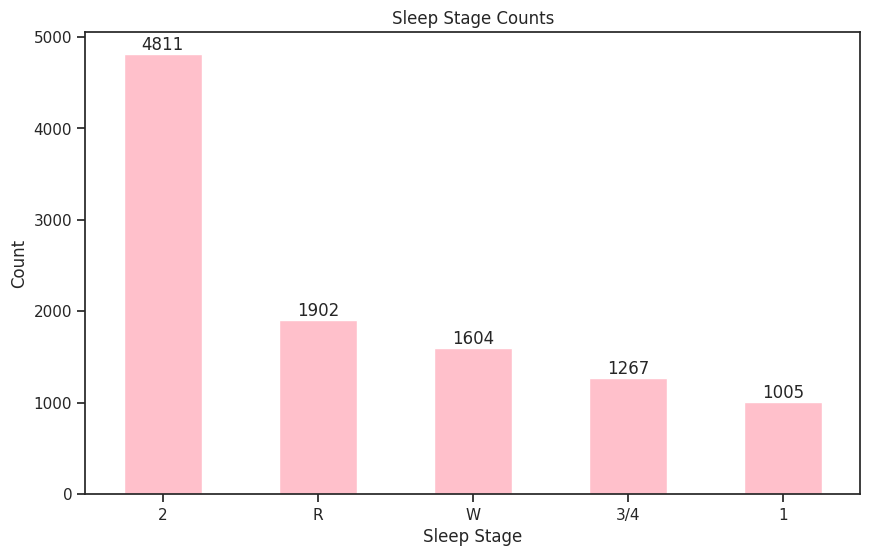

In [ ]:
# Use the 'value_counts' function to count the occurrences of each value in the 'Stage' column
stage_counts = combined_df['Stage'].value_counts()

# Define the mapping from numbers to sleep stages
stage_mapping = {1: 'W', 2: '1', 3: '2', 4: '3/4', 5: 'R'}

# Create a bar chart
plt.figure(figsize=(10, 6))
ax = stage_counts.plot(kind='bar', color='pink')  # Change the bar color to pink

# Customize the plot labels and title
plt.xlabel('Sleep Stage')
plt.ylabel('Count')
plt.title('Sleep Stage Counts')

# Update the X-axis labels using the mapping
ax.set_xticks(range(len(stage_counts.index)))
ax.set_xticklabels([stage_mapping[x] for x in stage_counts.index], rotation=0)

# Add data labels to the bars
for i, v in enumerate(stage_counts):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

# Show the bar chart
plt.show()


# Random Over Sampling

เพื่อแก้ปัญหา Class Imbalance

In [ ]:
from imblearn.over_sampling import RandomOverSampler

x = combined_df.iloc[:, :-1].copy()
y = combined_df.iloc[:, -1].copy()

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(x, y)

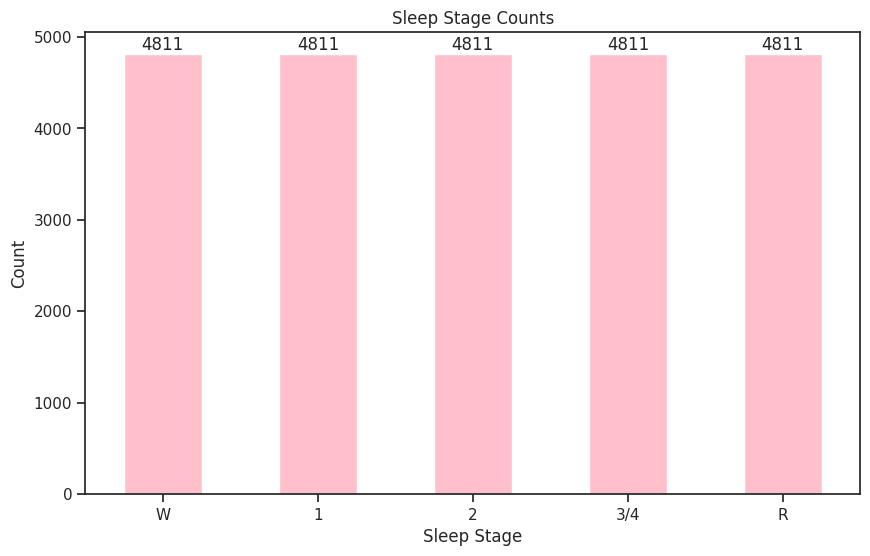

In [ ]:
resam_df = pd.DataFrame(y_resampled, columns=["Stage"])

# Use the 'value_counts' function to count the occurrences of each value in the 'Stage' column
stage_counts = resam_df['Stage'].value_counts()

# Define the mapping from numbers to sleep stages
stage_mapping = {1: 'W', 2: '1', 3: '2', 4: '3/4', 5: 'R'}

# Create a bar chart
plt.figure(figsize=(10, 6))
ax = stage_counts.plot(kind='bar', color='pink')  # Change the bar color to pink

# Customize the plot labels and title
plt.xlabel('Sleep Stage')
plt.ylabel('Count')
plt.title('Sleep Stage Counts')

# Update the X-axis labels using the mapping
ax.set_xticks(range(len(stage_counts.index)))
ax.set_xticklabels([stage_mapping[x] for x in stage_counts.index], rotation=0)

# Add data labels to the bars
for i, v in enumerate(stage_counts):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

# Show the bar chart
plt.show()

# Split Data

In [ ]:
from sklearn.model_selection import train_test_split

# สร้าง training data และ test data โดยแบ่งจากชุดข้อมูล x,y
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2,
                                                    stratify=y_resampled,
                                                    shuffle=True,
                                                    random_state=42)

print('Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[   1 3849]
 [   2 3849]
 [   3 3849]
 [   4 3848]
 [   5 3849]]
Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[  1 962]
 [  2 962]
 [  3 962]
 [  4 963]
 [  5 962]]


# Rescaling Data

In [ ]:
x_scaler = StandardScaler().fit(x_train)

x_scale_train = x_scaler.transform(x_train)
x_scale_test  = x_scaler.transform(x_test)

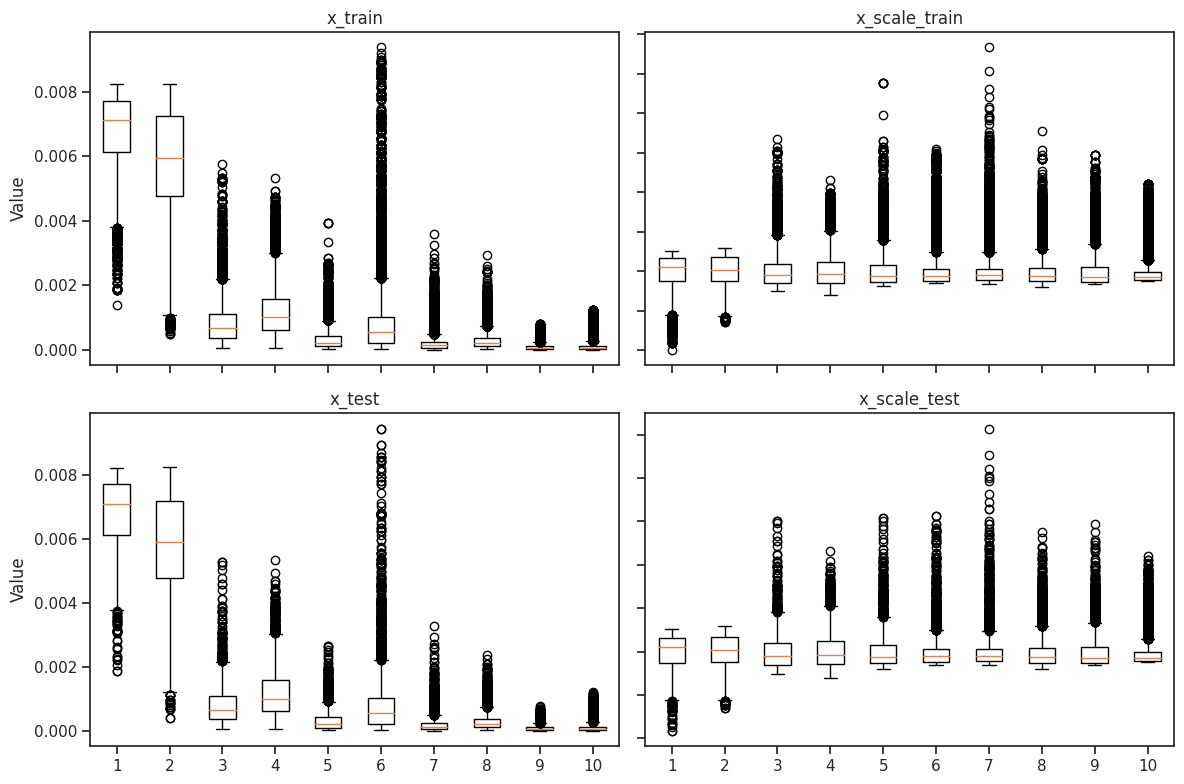

In [ ]:
# Create subplots in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Compare x_train and x_scale_train
axs[0, 0].boxplot(x_train)
axs[0, 0].set_title("x_train")
axs[0, 1].boxplot(x_scale_train)
axs[0, 1].set_title("x_scale_train")

# Compare x_test and x_scale_test
axs[1, 0].boxplot(x_test)
axs[1, 0].set_title("x_test")
axs[1, 1].boxplot(x_scale_test)
axs[1, 1].set_title("x_scale_test")

# Set y-axis label
for ax in axs.flat:
    ax.set(ylabel="Value")

# Add labels to the x-axis
for ax in axs.flat:
    ax.label_outer()

# Adjust layout for better appearance
plt.tight_layout()

# Show the boxplots
plt.show()


# Multiclass classification workflow using scikit-learn

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time

# ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
RANDOM_SEED = 42

In [ ]:
def tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test):

  # Record the start time
  start_time = time.time()

  # แบ่งข้อมูล training data ด้วย 5-fold cross-validation เพื่อ tune hyperparameter
  cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

  # ใช้ GridSearchCV เพื่อสอนโมเดลจากชุดค่า hyperparameters จาก clf_params
  # และคำนวณค่า accuracy ของแต่ละโมเดล เพื่อเลือกชุด hyperparameters ที่ดีที่สุด
  # โดยใช้เทคนิค cross-validation ในการแบ่งกลุ่ม validation data จาก training data
  tuned_clf = GridSearchCV(estimator=base_clf, param_grid=clf_params,
                            scoring=['accuracy'], refit='accuracy', cv=cv_splitter)

  # fit โมเดลด้วย training data
  tuned_clf.fit(x_train, y_train)

  # แสดงผล hyperparameters ที่ดีที่สุด และ cross-validation score
  print('Best hyperparameters: {}'.format(tuned_clf.best_params_))
  print("Best cross-validation score: {:.2f}".format(tuned_clf.best_score_))

  # ให้โมเดลทำนายค่า y จาก train data และคำนวณ accuracy score
  prediction_train = tuned_clf.predict(x_train)
  accuracy_train = accuracy_score(y_train, prediction_train)

  # ให้โมเดลทำนายค่า y จาก test data และคำนวณ accuracy score
  prediction_test = tuned_clf.predict(x_test)
  accuracy_test = accuracy_score(y_test, prediction_test)

  # แสดงผล classification ของโมเดลจาก training data และ test data
  print('Training Set: Classification report')
  print(classification_report(y_train, prediction_train))
  print('\nTest Set: Classification report')
  print(classification_report(y_test, prediction_test))

  # Define the class labels if you have them (optional)
  class_labels = ["W", "1", "2", "3/4", "R"]

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  # Choose a blue tone colormap, such as 'Blues'
  cmap = plt.get_cmap('Blues')

  # คำนวณและแสดง confusion matrix ของโมเดลจาก training data
  cm_train = confusion_matrix(y_train, prediction_train)
  display = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_labels)
  display.plot(ax=ax1, cmap=cmap)
  ax1.set_title('[Training Data] \nConfusion Matrix: tuned model')
  # คำนวณและแสดง confusion matrix จาก test data
  cm_test = confusion_matrix(y_test, prediction_test)
  display = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_labels)
  display.plot(ax=ax2, cmap=cmap)
  ax2.set_title('[Test Set] \nConfusion Matrix: tuned model')

  plt.tight_layout()
  plt.show()

  end_time = time.time()  # Record the end time
  training_time = end_time - start_time  # Calculate the training time
  training_time = training_time / 60 # Convert training time to minutes
  print("Processing time: {:.2f} minutes".format(training_time))

  return tuned_clf, [accuracy_train,accuracy_test], cm_train, cm_test, training_time

# Logistic Regression

Best hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.71
Training Set: Classification report
              precision    recall  f1-score   support

           1       0.83      0.74      0.78      3849
           2       0.56      0.45      0.50      3849
           3       0.83      0.69      0.75      3849
           4       0.77      0.92      0.84      3848
           5       0.60      0.77      0.67      3849

    accuracy                           0.71     19244
   macro avg       0.72      0.71      0.71     19244
weighted avg       0.72      0.71      0.71     19244


Test Set: Classification report
              precision    recall  f1-score   support

           1       0.82      0.71      0.76       962
           2       0.56      0.46      0.51       962
           3       0.81      0.69      0.74       962
           4       0.78      0.92      0.84       963
           5       0.61      0.77      0.68       962

    accurac

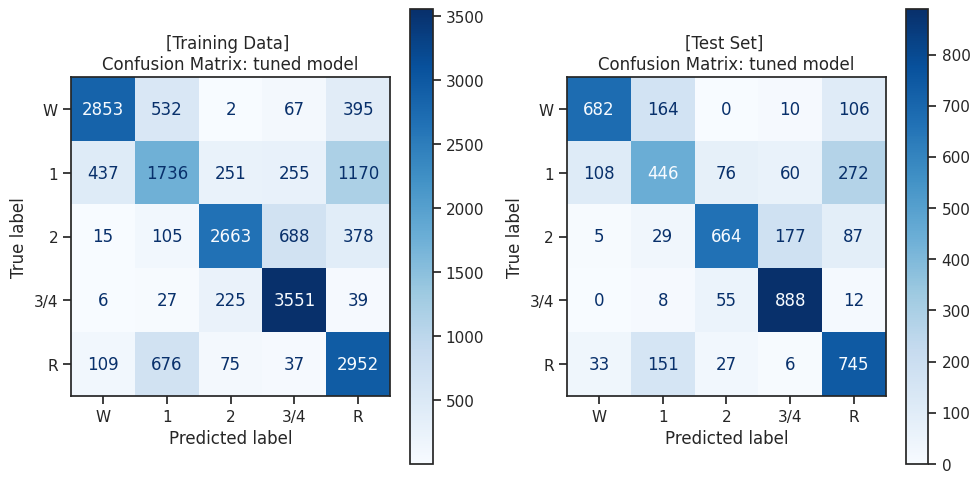

Processing time: 0.09 minutes


In [ ]:
# สร้างโมเดล และ กำหนดช่วงค่า hyperparameters ในรูปแบบ dictionary
base_clf = LogisticRegression()
clf_params = {'solver': ['liblinear'],
              'C': [0.01, 0.1, 1],
              'penalty': ['l2']
              }
tuned_logit, accuracy_logit, cm_train_logit, cm_test_logit, processing_logit_time = tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test)

# Support Vector Machine (SVM)

Best hyperparameters: {'C': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.79
Training Set: Classification report
              precision    recall  f1-score   support

           1       0.91      0.89      0.90      3849
           2       0.71      0.56      0.62      3849
           3       0.82      0.76      0.79      3849
           4       0.85      0.92      0.88      3848
           5       0.71      0.86      0.78      3849

    accuracy                           0.80     19244
   macro avg       0.80      0.80      0.80     19244
weighted avg       0.80      0.80      0.80     19244


Test Set: Classification report
              precision    recall  f1-score   support

           1       0.91      0.88      0.90       962
           2       0.68      0.54      0.60       962
           3       0.80      0.76      0.78       962
           4       0.84      0.92      0.88       963
           5       0.72      0.86      0.78       962

    accuracy                      

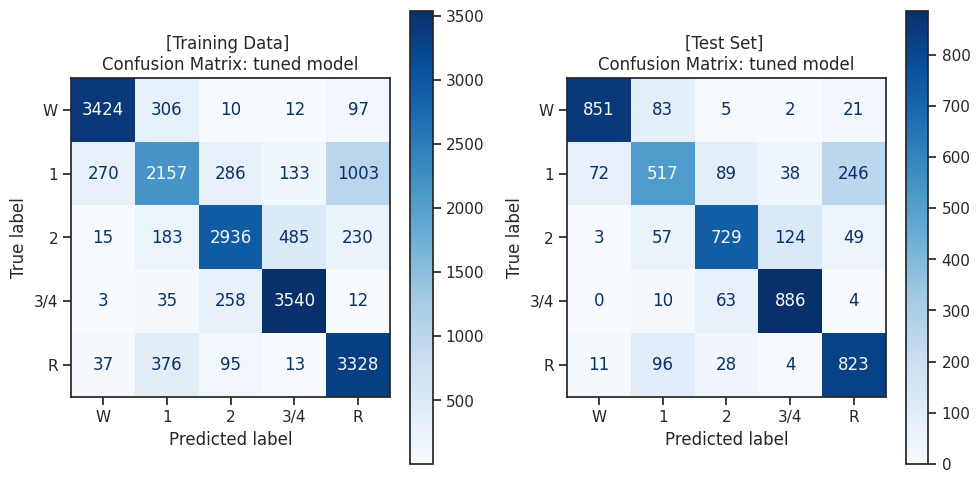

Processing time: 3.21 minutes


In [ ]:
# สร้างโมเดล และ กำหนดช่วงค่า hyperparameters ในรูปแบบ dictionary
base_clf = SVC(random_state=RANDOM_SEED)
clf_params = {'kernel': ['rbf','linear'],
              'C': [0.1, 1]
              }
tuned_svm, accuracy_svm, cm_train_svm, cm_test_svm, processing_svm_time = tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test)

# Random Forest (RF)

Best hyperparameters: {'max_depth': 5, 'n_estimators': 50}
Best cross-validation score: 0.76
Training Set: Classification report
              precision    recall  f1-score   support

           1       0.91      0.84      0.88      3849
           2       0.70      0.42      0.52      3849
           3       0.77      0.77      0.77      3849
           4       0.87      0.90      0.89      3848
           5       0.61      0.88      0.72      3849

    accuracy                           0.76     19244
   macro avg       0.77      0.76      0.75     19244
weighted avg       0.77      0.76      0.75     19244


Test Set: Classification report
              precision    recall  f1-score   support

           1       0.91      0.82      0.86       962
           2       0.66      0.42      0.51       962
           3       0.74      0.77      0.76       962
           4       0.87      0.89      0.88       963
           5       0.61      0.85      0.71       962

    accuracy           

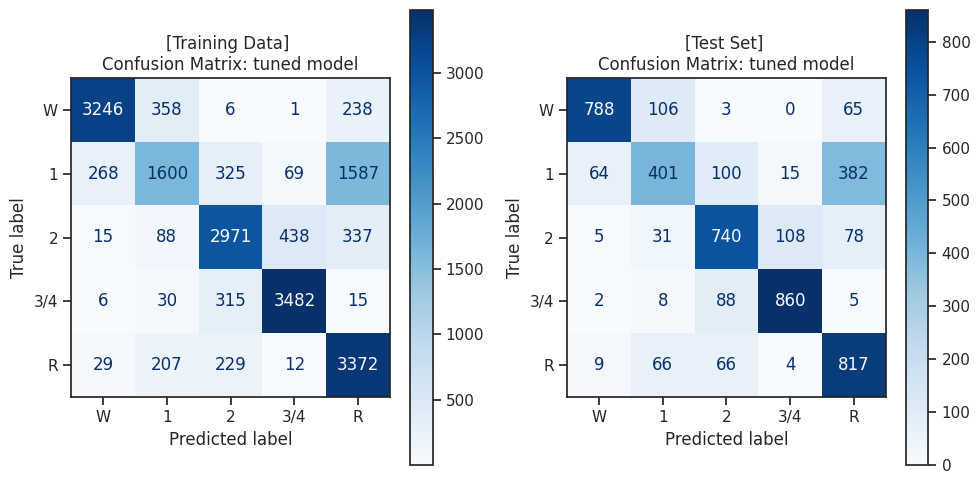

Processing time: 0.64 minutes


In [ ]:
# สร้างโมเดล และ กำหนดช่วงค่า hyperparameters ในรูปแบบ dictionary
base_clf = RFC(random_state=RANDOM_SEED)
clf_params = {'n_estimators': [10,50,100],
              'max_depth': [3,5]
              }
tuned_rf, accuracy_rf, cm_train_rf, cm_test_rf, processing_rf_time = tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test)

# k-Nearest Neighbor (k-NN)

Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation score: 0.93
Training Set: Classification report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3849
           2       1.00      1.00      1.00      3849
           3       1.00      1.00      1.00      3849
           4       1.00      1.00      1.00      3848
           5       1.00      1.00      1.00      3849

    accuracy                           1.00     19244
   macro avg       1.00      1.00      1.00     19244
weighted avg       1.00      1.00      1.00     19244


Test Set: Classification report
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       962
           2       0.89      0.99      0.94       962
           3       0.96      0.74      0.84       962
           4       0.90      0.99      0.94       963
           5       0.94      0.96      0.95       962

    accuracy      

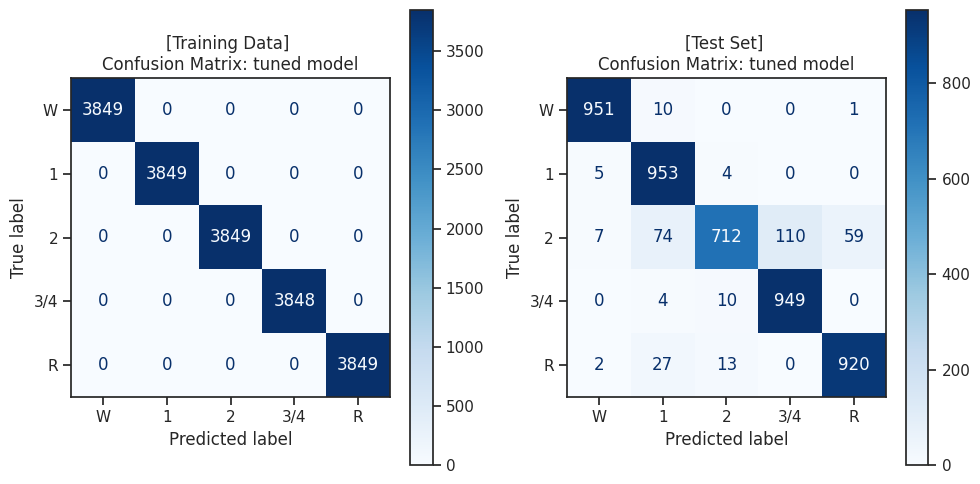

Processing time: 0.14 minutes


In [ ]:
# สร้างโมเดล และ กำหนดช่วงค่า hyperparameters ในรูปแบบ dictionary
base_clf = KNC()
clf_params = {'weights': ['uniform','distance'],
              'n_neighbors': [3, 5, 7]
              }
tuned_knn, accuracy_knn, cm_train_knn, cm_test_knn, processing_knn_time = tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test)

# Gradient Boosting Classifier

Best hyperparameters: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation score: 0.95
Training Set: Classification report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3849
           2       1.00      1.00      1.00      3849
           3       1.00      1.00      1.00      3849
           4       1.00      1.00      1.00      3848
           5       1.00      1.00      1.00      3849

    accuracy                           1.00     19244
   macro avg       1.00      1.00      1.00     19244
weighted avg       1.00      1.00      1.00     19244


Test Set: Classification report
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       962
           2       0.95      0.99      0.97       962
           3       0.97      0.87      0.92       962
           4       0.95      0.99      0.97       963
           5       0.96      0.96      0.96       962



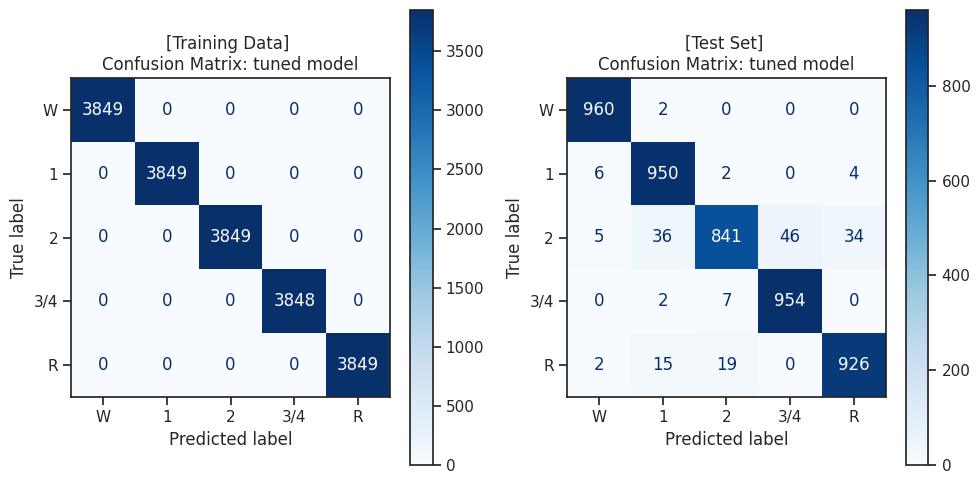

Processing time: 27.48 minutes


In [ ]:
# สร้างโมเดล และ กำหนดช่วงค่า hyperparameters ในรูปแบบ dictionary
base_clf = GBC()
clf_params = {
    'n_estimators': [200],  # The number of boosting stages (trees)
    'learning_rate': [0.2, 0.5],  # The step size shrinkage used to prevent overfitting
    'max_depth': [2, 5]  # Maximum depth of the individual trees
}
tuned_gb, accuracy_gb, cm_train_gb, cm_test_gb, processing_gb_time = tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test)

# Neural network models : Multi-layer Perceptron (MLP)

Best hyperparameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive'}
Best cross-validation score: 0.94
Training Set: Classification report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3849
           2       0.99      1.00      0.99      3849
           3       0.98      0.94      0.96      3849
           4       0.96      0.98      0.97      3848
           5       0.98      1.00      0.99      3849

    accuracy                           0.98     19244
   macro avg       0.98      0.98      0.98     19244
weighted avg       0.98      0.98      0.98     19244


Test Set: Classification report
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       962
           2       0.91      0.98      0.95       962
           3       0.95      0.84      0.89       962
           4       0.94      0.98      0.96       963
           

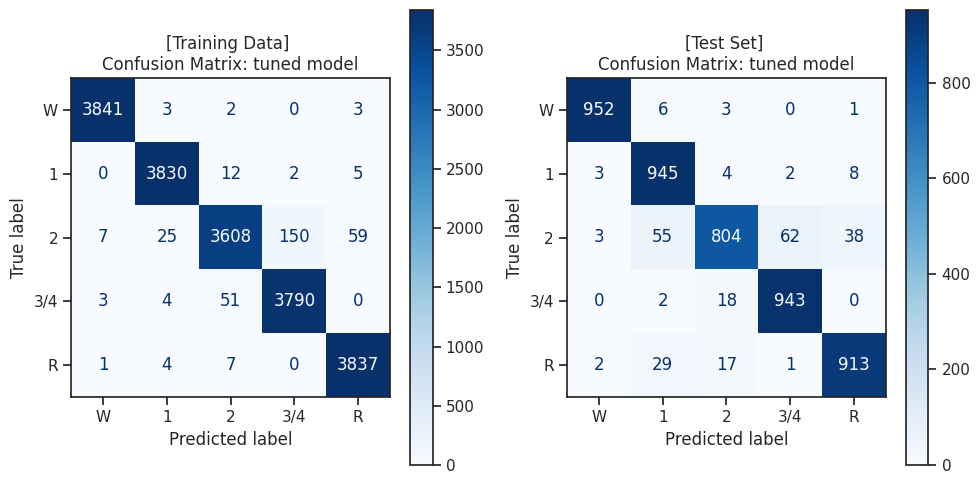

Processing time: 233.54 minutes


In [ ]:
# Define the base classifier and the hyperparameters to search over
base_clf = MLP(max_iter=1000)
clf_params = {
    'hidden_layer_sizes': [(50, 50, 50)],  # Size of hidden layers
    'activation': ['relu', 'tanh'],  # Activation function
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization term
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Learning rate schedule
}

# Use this base_clf and clf_params with your tune_train_test_pipeline function
tuned_mlp, accuracy_mlp, cm_train_mlp, cm_test_mlp, processing_mlp_time = tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test)

# ML Model Comparison (Accuracy)

In [ ]:
print('Accuracy Scores and Processing Times:')
pd.DataFrame({
    'Model': ['Logistic', 'SVM', 'RF', 'KNN', 'GBC', 'MLP'],
    'Train Accuracy': [accuracy_logit[0], accuracy_svm[0], accuracy_rf[0], accuracy_knn[0], accuracy_gb[0], accuracy_mlp[0]],
    'Test Accuracy': [accuracy_logit[1], accuracy_svm[1], accuracy_rf[1], accuracy_knn[1], accuracy_gb[1], accuracy_mlp[1]],
    'Processing Time (minutes)': [processing_logit_time, processing_svm_time, processing_rf_time, processing_knn_time, processing_gb_time, processing_mlp_time]
})

Accuracy Scores and Processing Times:


,Model,Train Accuracy,Test Accuracy,Processing Time (minutes)
0,Logistic,0.714768,0.711910,0.089167
1,SVM,0.799470,0.791104,3.213372
2,RF,0.762367,0.749532,0.638959
3,KNN,1.000000,0.932239,0.136461
4,GBC,1.000000,0.962586,27.483022
5,MLP,0.982436,0.947204,233.540487


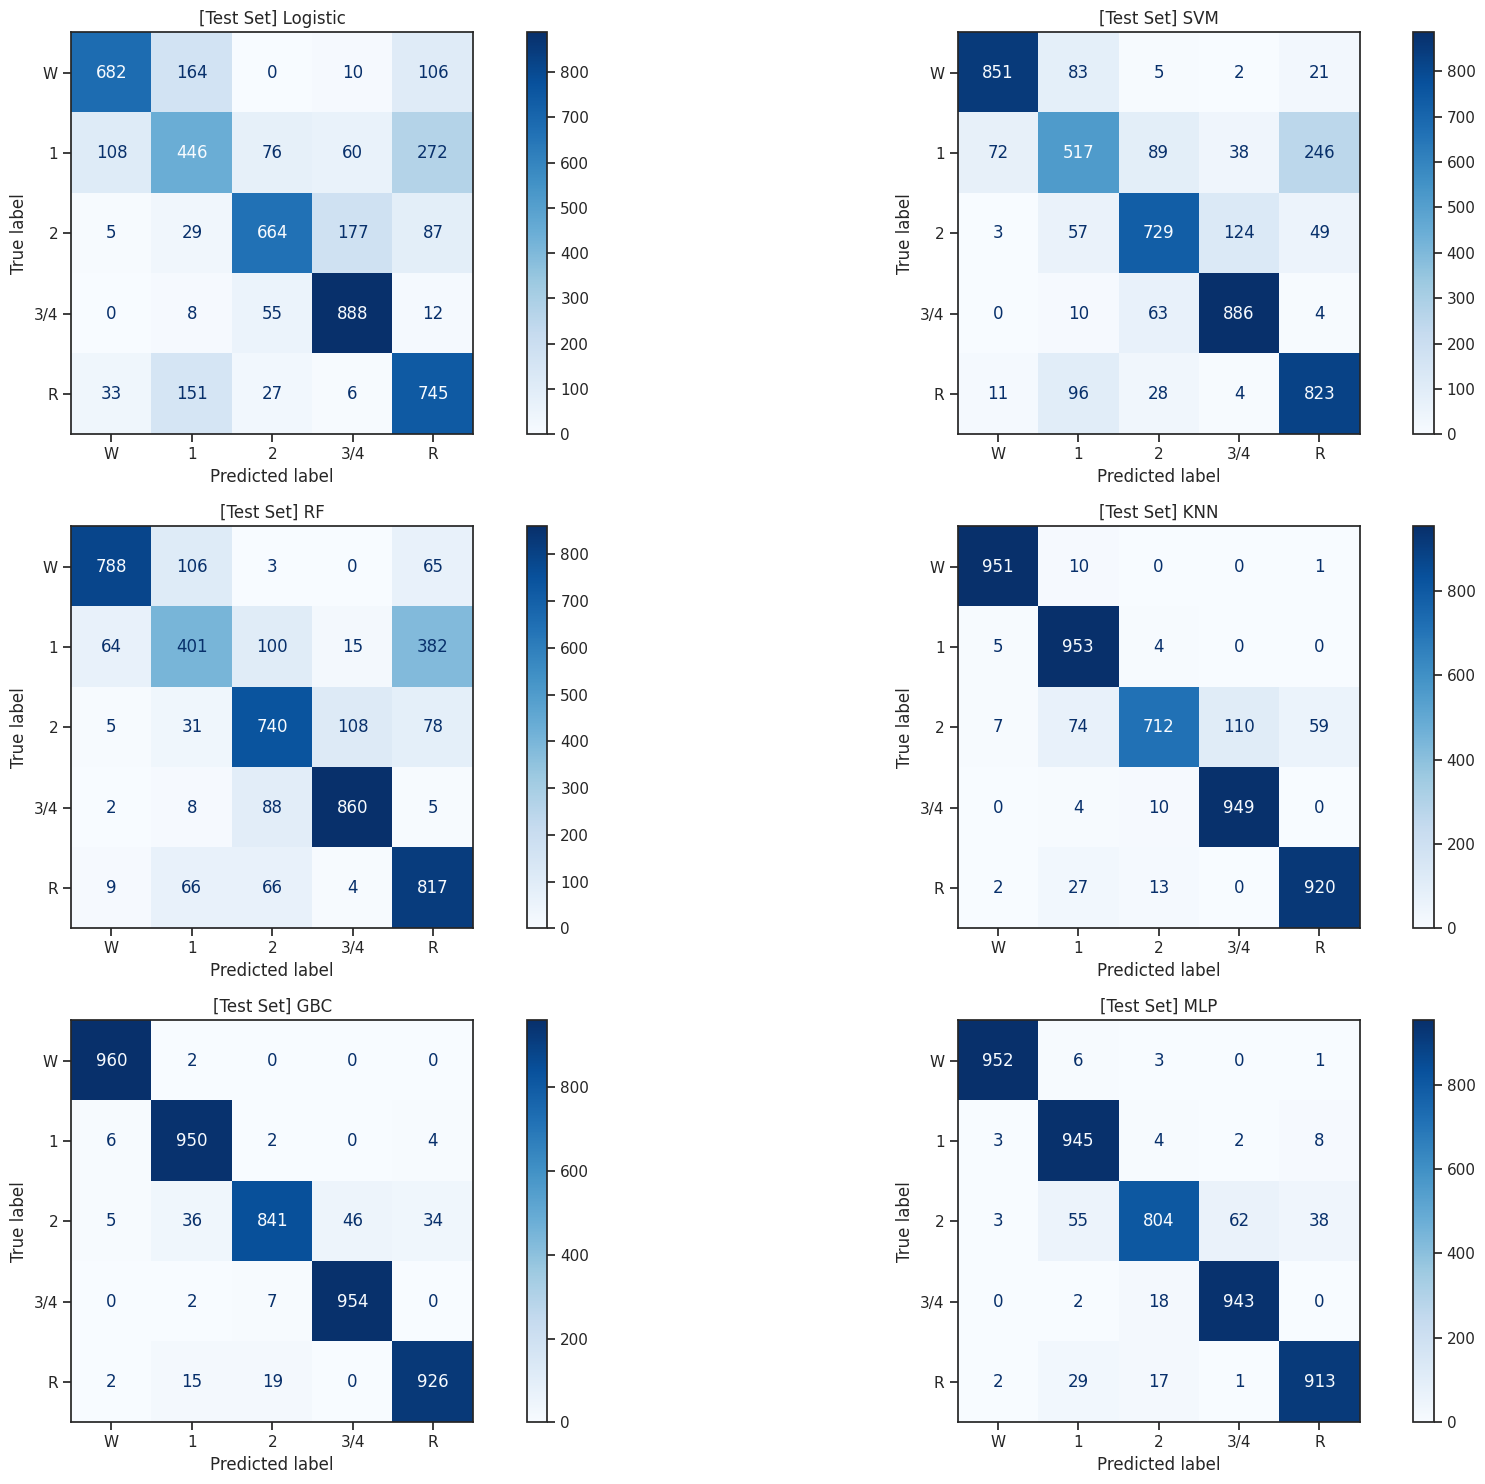

In [ ]:
# Define the class labels if you have them (optional)
class_labels = ["W", "1", "2", "3/4", "R"]
cmap = plt.get_cmap('Blues')

fig, axs = plt.subplots(3, 2, figsize=(20, 15))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
axs = axs.flatten()
cm = [cm_test_logit, cm_test_svm, cm_test_rf, cm_test_knn, cm_test_gb, cm_test_mlp]
model_name = ['Logistic', 'SVM', 'RF', 'KNN', 'GBC', 'MLP']
for i in range(6):
    display = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=class_labels)
    ax=axs[i]
    display.plot(ax=ax, cmap=cmap)
    ax.set_title('[Test Set] '+model_name[i])
plt.tight_layout()
plt.show()

# Reference

[Sleep stage classification from polysomnography (PSG) data](https://mne.tools/stable/auto_tutorials/clinical/60_sleep.html)

[EEG Analysis](https://course-braincodecamp.web.app/Fundamentals/MachineLearning/eeg_supervised_learning.html)